# Thinking direct battery contro(continuous) No generator.

# Coding in progresss..... Quadratic running cost + Terminal Cost  



# Issue

To find optimal control at each time step, we have 
$X_t$ = O-U Wind process, $I_t$ = SOC, $dI_t = B_t dt$ $B_t$ = Charge.
$V(t,X_t,I_t) = inf_{B_t} (X_t+B_t)^2 + V(t+1,X_{t+1},I_t + B_t dt $ where GP approximates $V(t+1)$. 
This is continuous control where we have derivative of GP. To solve FOC, how do we do this? No analytical solution since we dont know $v_{t+1}(\alpha_)$. May be root finding method for FOC.

I can also use NN for optimization...Hmmmmmmmmm

In [9]:
import numpy as np

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from scipy.stats import qmc
import sklearn.gaussian_process as gp
from scipy import optimize
from multiprocess import Pool
import GPy
# Batch design parameters
sites = 512; batch = 20; nsim = sites * batch

# parameters
 
    
maturity = 24 * 2 # units are in hours
global dt; dt = 15/60;
nstep = int(maturity/dt)
# B and I range
B_min = -6
B_max = 6
I_max = 10
# OU params
alpha = 0.5; m0 = 0; sigma = 2



In [10]:
def demandSimulate(α, m, σ, n_step, n_sim, maturity, P0,given_W = False, W = None):
    
    dt = maturity/n_step
    priceMatrix = np.zeros((n_sim, n_step+1))
    priceMatrix[:,0] = np.ones(n_sim) * P0
    
    if not given_W:
        dW = np.random.normal(0,1,size = (n_sim,n_step) ) * np.sqrt(dt)
    
    else:
        dW = W
    
    
    for i in range(1,n_step+1):
        priceMatrix[:,i] = priceMatrix[:,i-1] + α * (m - priceMatrix[:,i-1]) * dt + σ * dW[:,i-1]
        
    return priceMatrix

Running cost is quadractic. 


In [56]:
Model[0].predict(np.array([[0,5]]).reshape(1,-1))[0]

array([[2.64595353]])

In [11]:
def one_step_objective(B,X,I,mdl):
    next_step = np.array([X,I +B[0]*dt])

    objective_func = np.abs((X+B[0])**2) * dt + mdl.predict(next_step.reshape(1,-1))[0].flatten()[0]
    return objective_func
def minimize(args):
    f,x,i,mdl,lb,ub = args
    bnds = optimize.Bounds(lb, ub )
    res = optimize.minimize(f, x0=(lb+ub)/2, args=(x,i,mdl),method = "L-BFGS-B", bounds = bnds)
    return res.x[0]
def runner():
    sampler = qmc.Sobol(d=2, scramble=False)
    # 1024 samples : simple spacde fillling designs
    W = sampler.random_base2(m=10)
    X_prev = -4+8*W[:,0]; # X0 in [-4,4]
    I_next = 10*W[:,1];    # Ic in[0,Imax = 10]

    #create X_{T-1} to X_T
    demandMatrix = demandSimulate(alpha, m0, sigma, 1, len(X_prev), dt, X_prev);
    #V_T
    finalCost = 200 * np.maximum(5-I_next,0)
    # this gives E[V(t+1) | X_t-1 = x_(t-1)]

    costNext = finalCost;

    global Model ; Model = [None] * (nstep)
    gpMdl = None
    ctrl = None
    ctrlModel = [None] * (nstep)


    for iStep in range(nstep,0,-1):
        kernel =GPy.kern.Matern52(input_dim=2)

        X_train = np.column_stack((X_prev, I_next))
        y_train = costNext
        # E[V_t given X_t-1,I_t]
        print(iStep)
        print(costNext[:10])
        print("\n")
        gpMdl =  GPy.models.GPRegression(X_train,y_train.reshape(-1,1),kernel)
        # assuming we generated, X_t-2,I_t-1
        # create path from X_t-2 to X_t-1, then. we optimize on X_t-1, I_t-1+ Bt dt with V_t to get V_t-1
        demandMatrix = demandSimulate(alpha, m0, sigma, 1, len(X_prev), dt, X_prev);
        
        optimal_B = np.zeros(len(X_prev))
        
        ## Parallel Optimize B* as function of(Xt-1,I)
        LB = np.maximum(B_min, (-I_next)/dt)
        UB = np.minimum(B_max, (I_max-I_next)/dt)
        sample_num = len(X_prev)
        args =[(one_step_objective,demandMatrix[i,1],I_next[i],gpMdl,LB[i],UB[i]) for i in range(sample_num)]
        #p = Pool()
        #optimal_B = np.array(p.map(minimize,args))
        idx = 0
        for arg in args:
            optimal_B[idx] = minimize(arg)
            idx+=1

        kernel2 = GPy.kern.Matern32(input_dim=2)
        ctrl = GPy.models.GPRegression(np.column_stack((demandMatrix[:,1], I_next)), optimal_B.reshape(-1,1),kernel2)
        ctrlModel[iStep-1] = ctrl
        # this gives B*(X(t-1),I(t-1)) = argmin E[(B(t-1)+X(t-1))**2 + V(t+1,XT, I(t-1)+B(t-1)* dt) | x(t-1)]
        gp_test = np.column_stack((demandMatrix[:,1], I_next + optimal_B *dt))
        costNext = np.abs((demandMatrix[:,1]+optimal_B)**2) *dt +gpMdl.predict(gp_test)[0].flatten()
        
        
        Model[iStep-1] = gpMdl
    return Model,ctrlModel

In [12]:
conditional_exp, ctrls = runner()

192
[1000.    0.  500.    0.  250.    0.  750.    0.  375.    0.]


191
[ 6.97464592e+02 -3.90624152e+00  2.07770068e+02 -6.92146986e-03
  1.04555139e+01 -9.02800003e-02  4.56800972e+02 -9.12034996e-02
  8.02139280e+01  5.38439387e-02]


190
[ 3.89732456e+02 -2.75434415e+00  3.00383472e+01  1.12322877e-01
  7.60793159e-01 -1.59585267e-02  1.54797572e+02  1.34507075e-02
 -2.21913888e+00 -3.90206314e-02]


189
[ 1.05562435e+02 -8.47908213e-01  1.28332204e+01 -3.36215136e-02
 -3.14660074e+00  4.10689073e-02  2.63910884e+01  2.91599793e-02
 -3.33808691e+00 -2.50820569e-02]


188
[ 1.61680605  1.57154886 14.91979023 -0.45880433 -2.51998998 -1.48156751
 16.62854306  0.08517878 -0.99657897 -1.50343643]


187
[ 2.82600323 -1.61956958 15.73439054  0.14405719  0.80034084 -1.72489127
 17.78404269 -1.15858876 -1.67426648 -0.03541352]


186
[ 0.27516868  0.06838694 12.40058513  0.97885308 -0.07330165 -1.17604302
 14.19234169 -0.22873494  0.43469128 -0.4315578 ]


185
[ 2.65695817  1.26426045 14.190

124
[2.50263171 2.67419258 2.99405402 3.24815174 2.66308537 2.51315341
 3.02982323 3.07705817 2.45089431 2.69449272]


123
[2.35723817 2.6890492  2.98619231 3.73737329 2.68122721 2.87704173
 3.12254434 3.25508824 2.59246211 2.66579579]


122
[2.23764126 2.77993531 3.06653391 2.91994399 2.69104814 1.79198836
 3.56541303 3.22823193 2.65126922 2.61555174]


121
[2.45098069 2.72680661 2.78073276 3.5556501  2.52066124 1.8095714
 3.46342984 3.32532951 2.34567503 2.52794038]


120
[2.1912196  2.71345945 3.10347289 3.59571476 2.6648787  2.21395974
 2.87452585 3.14347287 2.51470842 2.62579054]


119
[0.47138092 2.84941547 3.52711915 2.83333438 2.680474   2.27314215
 2.82955167 3.00146898 2.59617685 2.66939056]


118
[2.46397051 2.69871605 3.09272778 2.95613503 2.76011842 2.59604079
 2.70247508 3.17192911 2.63888182 2.61976435]


117
[2.01189013 2.71434513 2.97513495 3.69379608 2.72099885 2.57287763
 3.57442725 2.62108052 2.67716504 2.73958023]


116
[1.89413052 2.67871367 2.8636391  3.47662515 

54
[2.72212306 2.49278735 3.46212819 3.8046071  2.44722607 2.23875937
 2.84470456 2.138017   1.13041827 2.44454549]


53
[1.84524903 2.54527598 3.5331002  3.22166713 2.43876881 2.28648587
 3.13962443 3.25252581 2.42490081 2.37845234]


52
[1.85505935 2.49512747 2.70867828 2.6247634  2.45098969 2.17453451
 3.30063236 3.26201539 2.33764488 2.60136224]


51
[2.09498727 2.50445461 2.95528916 3.69709174 2.48779364 2.17479274
 2.58620176 2.70668692 2.42346851 2.42522033]


50
[1.80234136 2.68196562 2.96789362 3.09142112 2.46663894 2.35009867
 4.13693971 3.05459115 2.33353909 2.30397973]


49
[1.01170195 2.52903718 3.48096633 3.28712345 2.52136476 2.52522027
 2.94819609 3.18701702 2.3096393  2.5096982 ]


48
[1.88290927 2.59211361 4.07651513 3.15789901 2.8661027  2.42584719
 2.88512364 3.1596837  2.52129952 2.48790489]


47
[2.41156128 2.59890062 2.99127447 3.40566909 2.55982454 2.65729879
 4.80837245 2.88946713 2.43756397 2.59109069]


46
[2.00713651 2.57822589 3.24252157 3.58744229 2.533988

Text(0.5, 1.0, 'B(t,demand = -2, I = 9)')

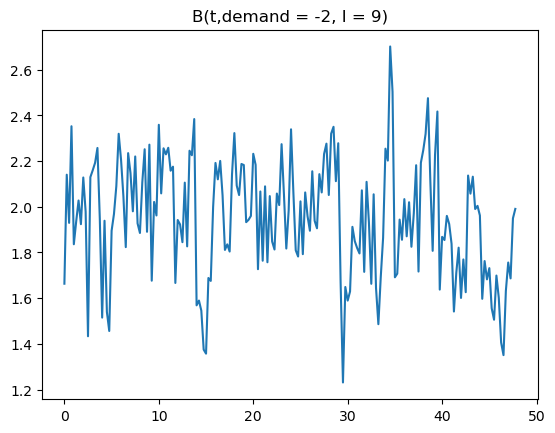

In [13]:
import matplotlib.pyplot as plt

t = np.linspace(0,47.75,nstep)
B_star = np.zeros(len(t))
for i in range(len(t)):
    inp = np.array([-2,9]).reshape(1,-1)
    B_star[i] = ctrls[i].predict(inp)[0].flatten()[0]
plt.plot(t,B_star)
plt.title("B(t,demand = -2, I = 9)")

In [15]:
191//2

95

In [31]:
X_range = np.arange(-4,4+0.1,0.01)
I_range  = np.arange(0,10+0.1,0.01)
B_range_t0 = np.zeros((len(I_range),len(X_range)))
B_range_tmid = np.zeros((len(I_range),len(X_range)))
B_range_t3_4 = np.zeros((len(I_range),len(X_range)))
B_range_tend = np.zeros((len(I_range),len(X_range)))
for i in range(len(X_range)):
    inp = np.column_stack((X_range[i] * np.ones(len(I_range)),I_range))
    B_range_t0[:,i] = ctrls[0].predict(inp)[0].flatten()
    B_range_tmid[:,i] = ctrls[nstep//2].predict(inp)[0].flatten()
    B_range_t3_4[:,i]= ctrls[-6].predict(inp)[0].flatten()
    B_range_tend[:,i] = ctrls[-1].predict(inp)[0].flatten()

In [464]:
B_range.shape

(1010, 810)

Bounds(array([-6.]), array([5.15625]))
-1.3409363665592677
1.3652318609131044 8.7109375


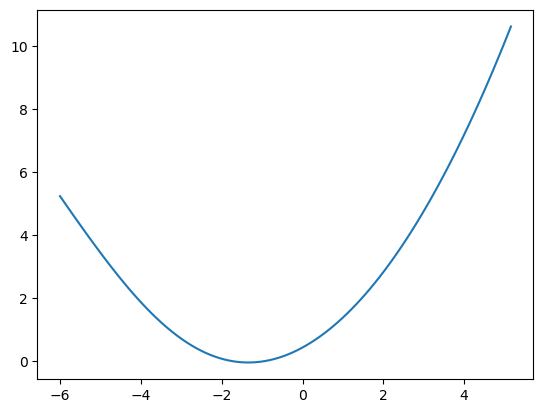

In [504]:
    
idx = np.random.randint(low = 0, high = 2**9)
X,I = demandMatrix[idx,1],I_next[idx]
lower_b = np.maximum(B_min, (-I)/dt)
upper_b = np.minimum(B_max, (I_max-I)/dt)
initial_guess = (lower_b+upper_b)/2
bnds = Bounds(lb=lower_b, ub = upper_b)
print(bnds)
# gradient is necessary for better estimates
result = minimize((one_step_objective,X,I,Model[-2],lower_b,upper_b))
print(result)
print(X,I)
B_range = np.linspace(lower_b,upper_b,100)
Vs = np.ones(len(B_range))
for i in range(len(B_range)):
    Vs[i] = one_step_objective([B_range[i]],X,I,Model[-2])
plt.plot(B_range,Vs)

In [388]:
#Model[0].predict_jacobian(X_train)

This is how the loop goes.

###  (1) Generate Design with N points {$x_{T-1},i_T$} . Create 1 step $x_{T-1} -> x_T$. Note, we will need to repeat {$x_{T-1},i_T$} M times as we will take expectation w.r.t  $X_T$ next step.   Compute $ E(V(X_T,i_T) | x_{T-1})$ by taking average over M observations of $x_{T}$, generated from {$x_{T-1}$}. Fit GP such that $ E(V(X_T,I_T) | x_{T-1})$ is response and $x_{t-1},i_T$ without repitition is input. So, GP is modeling conditional expectation  $ E(V(X_T,i_T) | x_{t-1})$ as a function of $(x_{t-1},i_T)$.

### (2) Now, generate design {$x_{T-2},i_{T-1}$}  with reptition M times each. Create 1 step $x_{T-2} -> x_{T-1}$. Our goal is $E[V(X_{T-1}, i_{T-1}) | x_{T-2} ]$ and fit GP. First, by DP, $V(x_{T-1}, i_{T-1}) = \min_{b_{T-1}} (i_{T-1} + b_{t-1})^2 + E[V(X_T,i_{T-1} + b_{T-1} dt)| x_{T-1}) =\min_{b_{T-1}} (i_{T-1} + b_{T-1})^2 + GP(x_{T-1},i_{T-1} + b_{T-1} dt)   $ First, 1-D hand optimize for all such $b_{T-1}$, (NM) total.  Plug it back in to get $V(x_{T-1}, i_{T-1})$. But that's not what we want, we want conditional expectations.

### Now, just like (1), we can compute $E[V(X_{T-1}, i_{T-1}) | x_{T-2} ]$ by taking average (size M),  to get N total $E[V(X_{T-1}, i_{T-1}) | x_{T-2} ]$  and use GP to learn w.r.t input  $(x_{t-2},i_{T-1})$

Repeat until T=0.


Note: I don't needanother iteration to optimize each $b_t$,  parallel optimized here.. Also, design points are uniform, can recreate based on $X_t$ distributions and uniform $I_t$. Can get really hudge example 1000 N*1000M = 10**6 

## Question: To reduce computation, If we skip repeated sampling (hence skip computing conditional expectation) and fit $v(x_T,i_T| x_{T-1}$)with GP, can GP output be interpreted as $E(v(X_T,I_T)| x_{T-1})?$. My thinking is no since GP output is $E(f^* | X,y,x^*)$ where expectation is taken wr.t. density of response $f^* $ or v. and not $X_T$. , so not exactly$ E(v(X_T,I_T)| x_{T-1})$. 

## But when are they equal? $f^*$and $X_T$ have same density and $f^*$ is independent of other data points (X-x,y)  Or simply, conditional densities are same. Not sure if they are. Can we match it?What are they?

## So, by doing expectation with repeated sampling and fit, we have double conditional expectation and smallest sigma algebra wins, so we have $ E(v(X_T,I_T)| x_{T-1})$ 

## Can use another GP to memorize analytically computed B*.Usefu ??? With formulation above, computing response B* is painful since it involes inverting NM matrix. 

# GP and poly issue: At first iterations, preds some are negative. Problematic . 

## GPs are really bad at fitting non negative response! Will give convergence failures and iterrations exceeded. How to solve? Ideas: log transform or very big prior mean. Log transform destroys conditional expectation.In fact, any non-linear transformations.   Aditya have any issue with original paper? 


## P.S: Design points of X can  come from it's distribution not Uniform.

Below is N sites, M reptition for each site. 

In [ ]:
def opt(B,X,I,mdl ):

    opt_data = np.array([X,I +B[0]*dt])
    objective_func = (X+B[0])**2 *dt + mdl.predict(opt_data.reshape(1,-1))
    return objective_func

def minimize(args):
    f,x,i,mdl,lb,ub = args
    bnds = optimize.Bounds(lb, ub )
    res = optimize.minimize(f, x0=(lb+ub)/2, args=(x,i,mdl),method = "L-BFGS-B", bounds = bnds)
    return res.x[0]

sites = 2**9 #(m=9)
batch = 20
sampler = qmc.Sobol(d=2, scramble=False)
# 1024 samples : simple spacde fillling designs
W = sampler.random_base2(m=9)
X_prev = -5+10*W[:,0]; # X0 in [-5,5]
I_next = 10*W[:,1];    # Ic in[0,Imax = 10]

X_prev_rep = np.repeat(X_prev,batch)
I_next_rep = np.repeat(I_next,batch)
#create X_{T-1} to X_T
demandMatrix = demandSimulate(alpha, m0, sigma, 1, len(X_prev_rep), dt, X_prev_rep);
#V_T
finalCost = 200 * np.maximum(5-I_next_rep,0)
# this gives E[V(t+1) | X_t-1 = x_(t-1)]
finalCost = np.mean(finalCost.reshape((batch,sites),order = "F"),axis = 0)

costNext = finalCost;

global Model ; Model = [None] * (nstep)
gpMdl = None


for iStep in range(nstep,0,-1):
    gpMdl = None
    kernel = gp.kernels.Matern( length_scale_bounds=(1e-10, 100000.0),nu=2.5)
    gpMdl = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.5, normalize_y=False)
    X_train = np.column_stack((X_prev, I_next))
    y_train = costNext
    # E[V_t given X_t-1,I_t]
    gpMdl.fit(X_train, y_train)
    
    # assuming we generated, X_t-2,I_t-1
    # create path from X_t-2 to X_t-1, then. we optimize on X_t-1, I_t-1+ Bt dt with V_t to get V_t-1
    demandMatrix = demandSimulate(alpha, m0, sigma, 1, len(X_prev_rep), dt, X_prev_rep);
    
    optimal_B = np.zeros(len(X_prev_rep))
    
    ## Parallel Optimize B* as function of(Xt-1,I)
    LB = np.maximum(B_min, (-I_next_rep)/dt)
    UB = np.minimum(B_max, (I_max-I_next_rep)/dt)
    sample_num = len(X_prev_rep)
    args =[(opt,demandMatrix[i,1],I_next_rep[i],gpMdl,LB[i],UB[i]) for i in range(sample_num)]
    p = Pool()
    optimal_B = np.array(p.map(minimize,args))

    
    
    # this gives B*(X(t-1),I(t-1)) = argmin E[(B(t-1)+X(t-1))**2 + V(t+1,XT, I(t-1)+B(t-1)* dt) | x(t-1)]
    gp_test = np.column_stack((demandMatrix[:,1], I_next_rep + optimal_B *dt))
    costNext = (demandMatrix[:,1]+optimal_B)**2 *dt + gpMdl.predict(gp_test)
    costNext = np.mean(costNext.reshape((batch, sites),order = "F"), axis=0)
        ###
    print(iStep)
    print(  (demandMatrix[:10,1]+optimal_B[:10])**2 *dt )

    print("\n")
    Model[iStep-1] = gpMdl
    



In [ ]:
import GPy
sampler = qmc.Sobol(d=2, scramble=False)
W = sampler.random_base2(m=9)
X_prev = -5+10*W[:,0]; # X0 in [-5,5]
I_next = 10*W[:,1];    # Ic in[0,Imax = 10]
# create instance of kernel
X_train = np.column_stack((X_prev, I_next))
finalCost = 200 * (np.maximum(5-I_next,0) ) 
# this gives E[V(t+1) | X_t-1 = x_(t-1)]

costNext = finalCost.reshape(-1,1)
k = GPy.kern.Matern52(input_dim=2)

# create instance of GP regression model
m = GPy.models.GPRegression(X_train,costNext,k)


## Polynomial regresion

Regression output gives negatve values ... 
Aditya's code same thing

In [108]:
polyMdl = LinearRegression()

X_train = np.column_stack((X_prev, I_next))
X_poly = poly.fit_transform(X_train)
y_train = finalCost
polyMdl.fit(X_train,y_train)
print(y_train[:10])
polyMdl.predict(X_train)[:10]

[500.    0.  250.    0.  125.    0.  375.    0.  187.5   0. ]


array([ 3.75730952e+02,  1.24998570e+02,  2.50364803e+02, -3.67663726e-01,
        1.87681665e+02, -6.30507175e+01,  3.13047899e+02,  6.23154320e+01,
        2.19023203e+02, -3.17091801e+01])

In [133]:
def opt(B,X,I,mdl ):

    opt_data = np.array([X,I +B[0]*dt])
    poly = preprocessing.PolynomialFeatures(degree=3)
    opt_data = poly.fit_transform(opt_data.reshape(1,-1))
    objective_func = (X+B[0])**2 *dt + np.maximum(mdl.predict(opt_data.reshape(1,-1)),0)
    return objective_func

def minimize(args):
    f,x,i,mdl,lb,ub = args
    bnds = optimize.Bounds(lb, ub )
    res = optimize.minimize(f, x0=(lb+ub)/2, args=(x,i,mdl),method = "L-BFGS-B", bounds = bnds)
    return res.x[0]
k = 9
sites = 2**k #(m=9)
batch = 100
sampler = qmc.Sobol(d=2, scramble=False)
# 1024 samples : simple spacde fillling designs
W = sampler.random_base2(m=k)
X_prev = -5+10*W[:,0]; # X0 in [-5,5]
I_next = 10*W[:,1];    # Ic in[0,Imax = 10]

#create X_{T-1} to X_T
demandMatrix = demandSimulate(alpha, m0, sigma, 1, len(X_prev), dt, X_prev);
#V_T
finalCost = 200 * np.maximum(5-I_next,0)
# this gives E[V(t+1) | X_t-1 = x_(t-1)]

costNext = finalCost;

global Model ; Model = [None] * (nstep)
polyMdl = None


for iStep in range(nstep,0,-1):
    polyMdl = LinearRegression()

    X_train = np.column_stack((X_prev, I_next))
    poly = preprocessing.PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X_train)
    idx = np.random.randint(0,512,size = 10)
    y_train = costNext
    print(y_train[idx])
    # E[V_t given X_t-1,I_t]
    polyMdl.fit(X_poly, y_train)

    # assuming we generated, X_t-2,I_t-1
    # create path from X_t-2 to X_t-1, then. we optimize on X_t-1, I_t-1+ Bt dt with V_t to get V_t-1
    demandMatrix = demandSimulate(alpha, m0, sigma, 1, len(X_prev), dt, X_prev);
    
    optimal_B = np.zeros(len(X_prev))
    
    ## Parallel Optimize B* as function of(Xt-1,I)
    LB = np.maximum(B_min, (-I_next)/dt)
    UB = np.minimum(B_max, (I_max-I_next)/dt)
    sample_num = len(X_prev)
    args =[(opt,demandMatrix[i,1],I_next[i],polyMdl,LB[i],UB[i]) for i in range(sample_num)]
    p = Pool()
    optimal_B = np.array(p.map(minimize,args))

    
    
    # this gives B*(X(t-1),I(t-1)) = argmin E[(B(t-1)+X(t-1))**2 + V(t+1,XT, I(t-1)+B(t-1)* dt) | x(t-1)]
    poly_test = np.column_stack((demandMatrix[:,1], I_next + optimal_B *dt))
    poly = preprocessing.PolynomialFeatures(degree=3)
    poly_test = poly.fit_transform(poly_test)
    costNext = np.maximum((demandMatrix[:,1]+optimal_B)**2 *dt +polyMdl.predict(poly_test),0)


    #print(costNext[:5])
    #print((demandMatrix[:5,1]+optimal_B[:5])**2 *dt)
    print(iStep)
    print("\n")


    print("\n")
    Model[iStep-1] = polyMdl
    

[  0.        0.        0.        0.      488.28125   0.      808.59375
 699.21875   0.        0.     ]
192




[ 16.99620322   0.           0.           0.         193.21960626
   0.         322.53516009 508.49089731 193.21960626   7.54565175]
191




[2.70274563e+01 0.00000000e+00 3.40287872e+01 3.60282685e-02
 6.07312689e-01 9.39148573e+01 3.01424051e+02 7.70844787e+00
 5.91203128e+00 2.38462052e+00]
190




[  0.           1.03234902   0.           0.           0.
   0.93818603   0.80251471   0.           3.59595027 159.18631971]
189




[ 5.37010287  0.         18.82356403 21.53229639  0.07626789 11.04666651
 12.73046062  0.          9.92158786  0.        ]
188




[6.44079866e-03 2.49918357e+00 1.43807091e+01 4.84592498e+00
 9.46812898e-01 2.50936484e+01 0.00000000e+00 0.00000000e+00
 5.31009704e+01 9.80065731e+00]
187




[ 5.34823412  3.77550827  4.65763021  4.18956509  5.10216673 44.92962354
 22.73771836 24.69438404  0.52551464  0.        ]
186




[32.30021212  7.5111028   8.4

130




[21.61305738 30.27873732 28.64999572 20.81280619 27.05761984 22.30672489
 20.16545145 21.17635671 23.05597018 20.14335722]
129




[25.83083679 21.10403328 28.89293295 21.29980272 23.30432946 26.68170086
 22.08930209 21.03014457 21.00553802 20.63480349]
128




[20.76217997 24.34922242 24.1895925  22.80106603 21.24941479 39.42315881
 38.09587234 36.78464304 22.18865654 25.31708591]
127




[24.61164183 24.07223872 25.10635381 21.23347959 27.15679415 23.47114013
 26.76923738 23.83164245 24.34264328 46.29415738]
126




[21.94426025 22.56503982 20.98241922 21.20226644 21.7413594  21.16206127
 25.1683513  32.48410819 21.25801103 25.31713218]
125




[21.66479919 21.4603438  21.32296096 22.85939532 30.00983712 21.95493047
 21.55423897 24.27938947 25.6787796  31.12237251]
124




[23.36872878 21.99134754 22.7966137  36.0949171  21.85523227 22.05440652
 45.57756198 25.67176063 21.86676946 24.99362915]
123




[21.29273284 22.50231981 22.50978329 29.27093613 26.25907314 24.40269646
 2

67




[41.08570014 45.25187088 50.00214642 39.46010638 40.92410539 45.70741241
 39.66190722 40.10229852 42.11744544 44.64485155]
66




[40.70115399 39.89463654 45.89023026 40.44162667 39.30456432 39.91633716
 42.53243301 42.46136179 60.58767798 52.48405556]
65




[39.81484246 40.36717334 39.70311807 43.05836024 40.30063158 42.47160508
 40.11512361 43.32185345 47.7848186  51.90836106]
64




[57.60754028 43.15567985 40.21580979 46.45394252 40.30034022 42.03246236
 40.18279773 58.90740288 59.16971293 40.57858699]
63




[46.51117533 40.71442727 43.68866591 43.4935049  46.63916398 52.66500999
 48.1368381  41.76782512 42.7208349  42.14931299]
62




[40.56133766 48.43289326 45.45549496 41.88377003 43.29454394 49.17743581
 40.83443127 42.05393685 45.17836913 44.19592101]
61




[43.09350022 45.65754479 42.79472665 42.77322038 42.60736966 41.08990899
 41.88282383 42.79472665 42.99177764 45.99135037]
60




[49.56315389 58.52590539 60.57470063 46.48358759 41.66313945 43.13157358
 41.715628

3




[65.27611659 66.28058028 62.90258133 69.11844655 65.12491538 62.63243054
 63.12764562 62.98396469 64.92400574 65.70125818]
2




[ 95.88598599 100.74099383  63.34658344  63.37152577  63.38615282
  63.36503308  66.04287272  63.41013177  63.57196506  63.70772308]
1






To compute, optimal B, using conditional q estimated by GP + parallel optimization.

In [192]:

def optimal_V(I0,X0,noise):
    Xs = demandSimulate(alpha, m0, sigma, nstep, 1000, maturity, X0,given_W = True, W = noise)
    Bts = np.zeros((1000,nstep))
    Is = np.zeros((1000,nstep+1))
    Is[:,0] = I0
    imbalance = np.zeros((1000,nstep))
    running_cost = np.zeros((1000,nstep))


    for i in range(nstep):
        ## Parallel Optimize B* as function of(Xt-1,I)
        LB = np.maximum(B_min, (-Is[:,i])/dt)
        UB = np.minimum(B_max, (I_max-Is[:,i])/dt)
        sample_num = len(LB)
        args =[(opt,Xs[idx,i],Is[idx,i],Model[i],LB[idx],UB[idx]) for idx in range(sample_num)]
        p = Pool()
        optimal_B = np.array(p.map(minimize,args))
        ###
        Bts[:,i] = optimal_B
        Is[:,i+1] = Is[:,i]+Bts[:,i]*dt
        imbalance[:,i] = Bts[:,i] +Xs[:,i]
        running_cost[:,i] = (Xs[:,i]+Bts[:,i])**2 *dt 
        #print(i)
    total_running_cost = np.sum(running_cost,axis = 1)
    total_cost = np.mean(total_running_cost+200 * np.maximum(5-Is[:,-1],0))

    return Xs,Is,Bts,imbalance,total_cost, total_running_cost
#noise = np.random.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
#X,I,B,imbalance,total_cost,total_running_cost = optimal_V(5,0,noise)

In [193]:
noise = np.random.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
X,I,B,imbalance,total_cost,total_running_cost = optimal_V(5,0,noise)



In [205]:
total_cost

105.19812893078503

In [206]:
X_range = np.arange(-5,5+0.1,0.1)
I_range  = np.arange(0,10+0.1,0.1)

LB = np.maximum(B_min, (-I_range)/dt)
UB = np.minimum(B_max, (I_max-I_range)/dt)
sample_num = len(LB)
opt_ctrl =  np.zeros((len(I_range),len(X_range)))
for i in range(len(X_range)):
    # compute optimization for fix X, all I
    args =[(opt,X_range[i],I_range[idx],Model[0],LB[idx],UB[idx]) for idx in range(sample_num)]
    p = Pool()
    optimal_B = np.array(p.map(minimize,args))
    opt_ctrl[:,i] = optimal_B
    

Process ForkPoolWorker-62743:
Process ForkPoolWorker-62736:
Process ForkPoolWorker-62737:
Process ForkPoolWorker-62740:
Process ForkPoolWorker-62739:
Process ForkPoolWorker-62738:
Process ForkPoolWorker-62741:
Process ForkPoolWorker-62742:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/taung/miniconda3/envs/energy_mike/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/taung/miniconda3/envs/energy_mike/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/taung/miniconda3/envs/energy_mike/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/taung/miniconda3/envs/energy_mike/li

In [460]:
X_range = np.arange(-5,5+0.1,0.01)
I_range  = np.arange(0,10+0.1,0.01)
noise = np.random.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
total_cost = np.zeros((len(I_range),len(X_range)))

for i in range(len(X_range)):
    for j in range(len(I_range)):
        total_cost[j,i] = optimal_V(I_range[j],X_range[i],noise)[4]
        #opt_ctrl[j,i] = control_Model[0].predict(np.array([X_range[i],I_range[j]]).reshape(1,-1))
        #lower_b = np.maximum(B_min, (-I_range[j])/dt)
        #upper_b = np.minimum(B_max, (I_max-I_range[i])/dt)
        #opt_ctrl[j,i] = np.minimum(opt_ctrl[j,i],upper_b)
        #opt_ctrl[j,i]= np.maximum(opt_ctrl[j,i],lower_b)
        print("Cost: " + str(total_cost[j,i]))

NameError: name 'optimal_V' is not defined

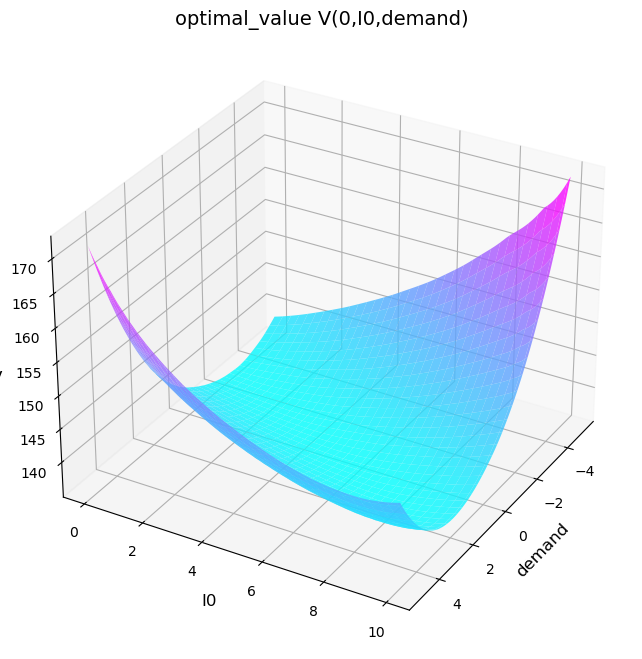

In [83]:
X, Y = np.meshgrid(X_range, I_range)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d') 
ax.plot_surface(X, Y, total_cost, cmap='cool', alpha=0.8)
ax.set_title('optimal_value V(0,I0,demand) ', fontsize=14)
ax.view_init(30, 30)
ax.set_xlabel('demand', fontsize=12)
ax.set_ylabel('I0', fontsize=12)
ax.set_zlabel('V', fontsize=12)
plt.show()

In [60]:
np.zeros((1,1))

array([[0.]])

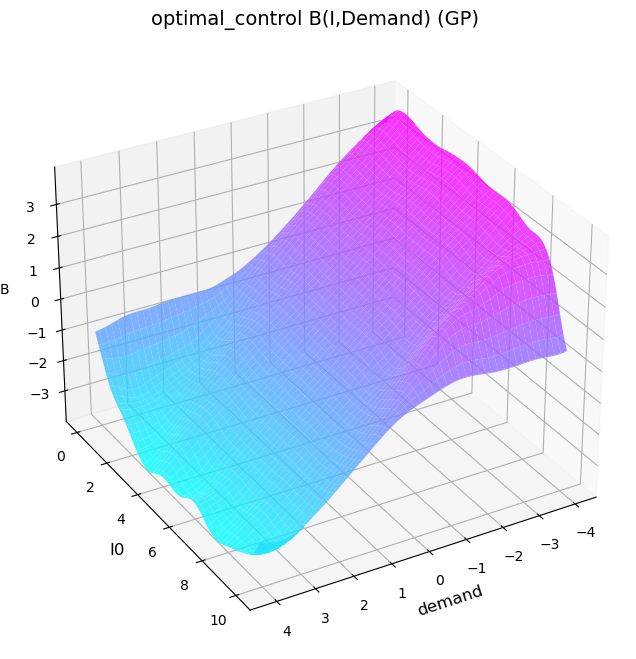

In [32]:
X, Y = np.meshgrid(X_range, I_range)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d') 
ax.plot_surface(X, Y, B_range_tmid, cmap='cool', alpha=0.8)
ax.set_title('optimal_control B(I,Demand) (GP) ', fontsize=14)
ax.set_xlabel('demand', fontsize=12)
ax.view_init(30, 60)
ax.set_ylabel('I0', fontsize=12)
ax.set_zlabel('B', fontsize=10)
plt.show()

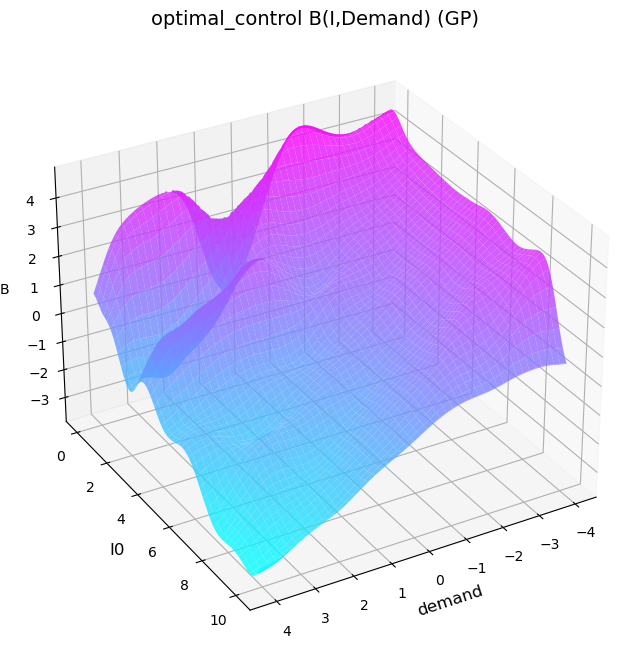

In [33]:
X, Y = np.meshgrid(X_range, I_range)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d') 
ax.plot_surface(X, Y, B_range_t3_4, cmap='cool', alpha=0.8)
ax.set_title('optimal_control B(I,Demand) (GP) ', fontsize=14)
ax.set_xlabel('demand', fontsize=12)
ax.view_init(30, 60)
ax.set_ylabel('I0', fontsize=12)
ax.set_zlabel('B', fontsize=10)
plt.show()

In [40]:
a = "2 3 ".split()

False

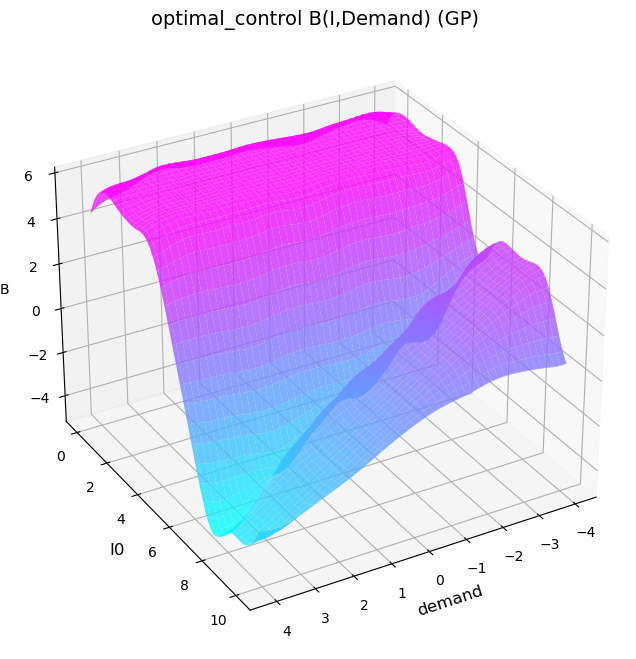

In [34]:
X, Y = np.meshgrid(X_range, I_range)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d') 
ax.plot_surface(X, Y, B_range_tend, cmap='cool', alpha=0.8)
ax.set_title('optimal_control B(I,Demand) (GP) ', fontsize=14)
ax.set_xlabel('demand', fontsize=12)
ax.view_init(30, 60)
ax.set_ylabel('I0', fontsize=12)
ax.set_zlabel('B', fontsize=10)
plt.show()

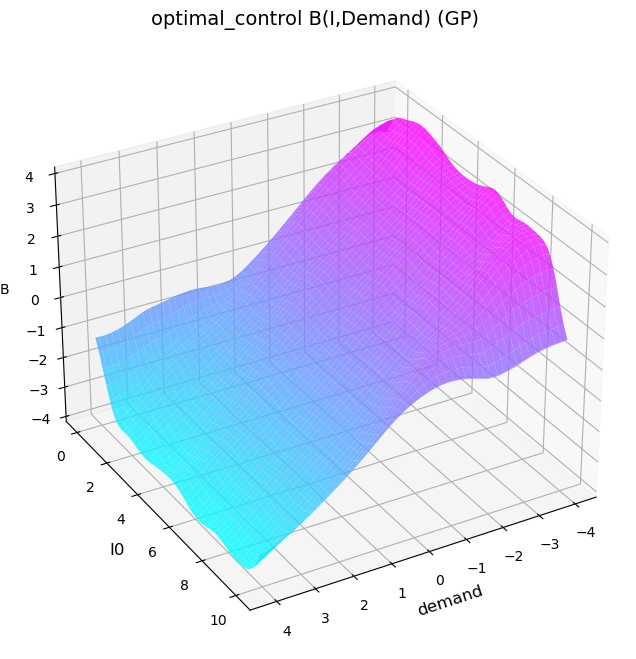

In [35]:
X, Y = np.meshgrid(X_range, I_range)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d') 
ax.plot_surface(X, Y, B_range_t0, cmap='cool', alpha=0.8)
ax.set_title('optimal_control B(I,Demand) (GP) ', fontsize=14)
ax.set_xlabel('demand', fontsize=12)
ax.view_init(30, 60)
ax.set_ylabel('I0', fontsize=12)
ax.set_zlabel('B', fontsize=10)
plt.show()

$B^*(0) = - demand - \frac{dV}{dI}(0,I,demand)$  
So, negative slope(linear) along demand. Question. When does the derivative becomes activated?

In [485]:
len(X_range)

810

In [488]:
X_range[800]

3.9999999999998295

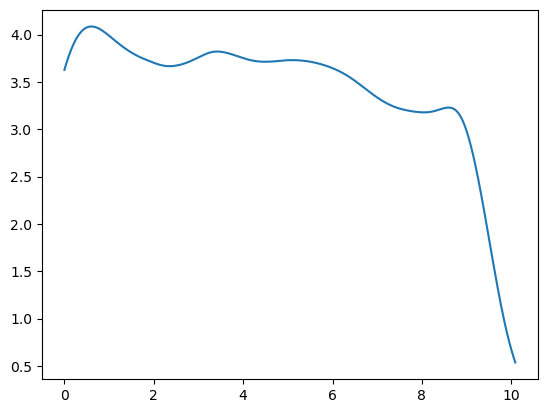

In [497]:
plt.plot(I_range,B_range[:,0])

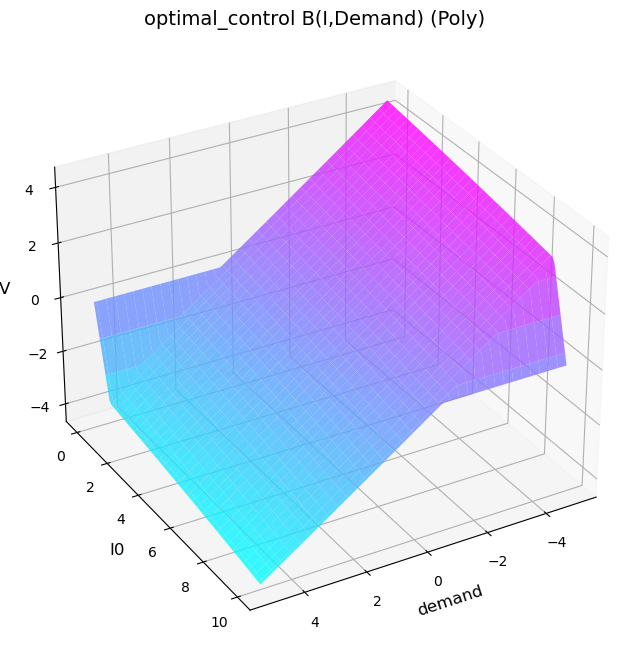

In [207]:
X, Y = np.meshgrid(X_range, I_range)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d') 
ax.plot_surface(X, Y, opt_ctrl, cmap='cool', alpha=0.8)
ax.set_title('optimal_control B(I,Demand) (Poly) ', fontsize=14)
ax.set_xlabel('demand', fontsize=12)
ax.view_init(30, 60)
ax.set_ylabel('I0', fontsize=12)
ax.set_zlabel('V', fontsize=12)
plt.show()

# Below GP has error. We didn't model for demand >0 by bug. On top of optimization errors.

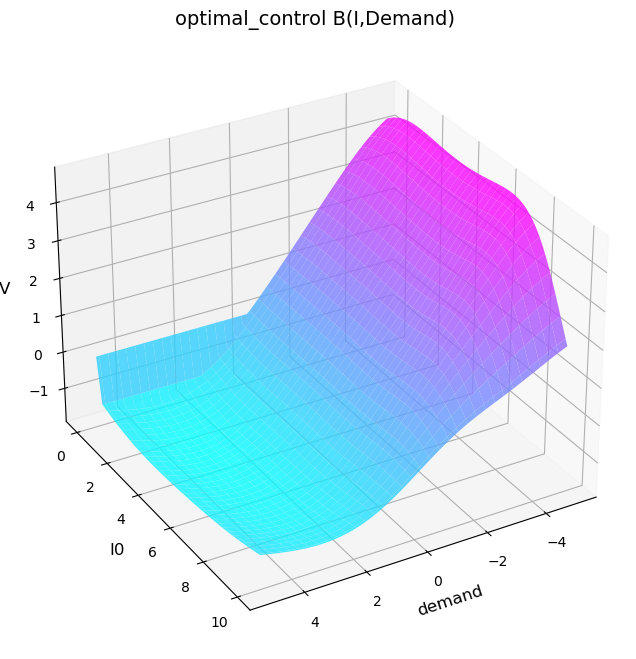

In [84]:
X, Y = np.meshgrid(X_range, I_range)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d') 
ax.plot_surface(X, Y, opt_ctrl, cmap='cool', alpha=0.8)
ax.set_title('optimal_control B(I,Demand) ', fontsize=14)
ax.set_xlabel('demand', fontsize=12)
ax.view_init(30, 60)
ax.set_ylabel('I0', fontsize=12)
ax.set_zlabel('V', fontsize=12)
plt.show()

In [23]:
noise = np.random.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
X,I,B,imbalance,cost_,total_running_cost = optimal_V(5,0,noise)

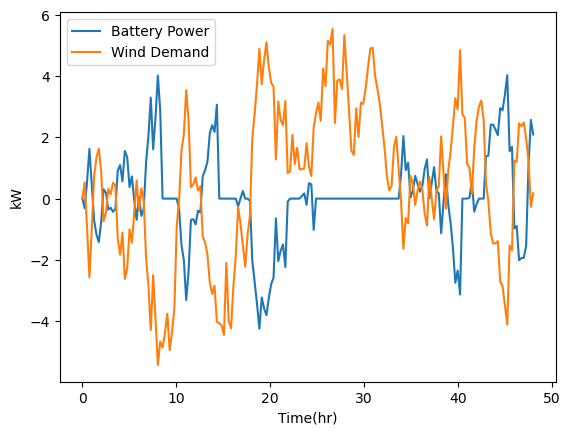

In [28]:
import matplotlib.pyplot as plt
t = np.linspace(0,48,192)
plt.plot(t,B[100,:])
plt.plot(t,X[100,:-1])
plt.xlabel("Time(hr)")
plt.ylabel("kW")
plt.legend(["Battery Power","Wind Demand" ])

[]

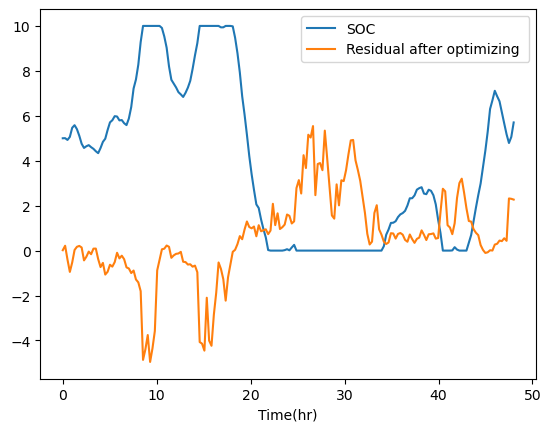

In [29]:
plt.plot(t,I[100,:-1])
plt.plot(t,imbalance[100,:])
plt.xlabel("Time(hr)")

plt.legend(["SOC","Residual after optimizing " ])
plt.plot()